## PySpark setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create a Spark Session

In [ ]:
import findspark

findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

## Loading data from CSV

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor, RandomForestRegressor, LinearRegression, GeneralizedLinearRegression, DecisionTreeRegressor
from pyspark.sql import functions as F
from pyspark.sql.window import Window

#pfile = "data_stocks.csv"
pfile = "/content/drive/My Drive/AAPL.csv"

_pdf = spark.read.option("header",True).option("inferSchema",True).csv(pfile)
_pdf.printSchema()
_pdf.show()
_pdf.count()
_pdf.tail(10)

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|1980-12-12|0.128348|0.128906|0.128348|0.128348| 0.099874|469033600|
|1980-12-15| 0.12221| 0.12221|0.121652|0.121652| 0.094663|175884800|
|1980-12-16|0.113281|0.113281|0.112723|0.112723| 0.087715|105728000|
|1980-12-17|0.115513|0.116071|0.115513|0.115513| 0.089886| 86441600|
|1980-12-18|0.118862| 0.11942|0.118862|0.118862| 0.092492| 73449600|
|1980-12-19|0.126116|0.126674|0.126116|0.126116| 0.098137| 48630400|
|1980-12-22|0.132254|0.132813|0.132254|0.132254| 0.102913| 37363200|
|1980-12-23|0.137835|0.138393|0.137835|0.137835

[Row(Date='2022-11-14', Open=148.970001, High=150.279999, Low=147.429993, Close=148.279999, Adj Close=148.279999, Volume=73374100),
 Row(Date='2022-11-15', Open=152.220001, High=153.589996, Low=148.559998, Close=150.039993, Adj Close=150.039993, Volume=89868300),
 Row(Date='2022-11-16', Open=149.130005, High=149.869995, Low=147.289993, Close=148.789993, Adj Close=148.789993, Volume=64218300),
 Row(Date='2022-11-17', Open=146.429993, High=151.479996, Low=146.149994, Close=150.720001, Adj Close=150.720001, Volume=80389400),
 Row(Date='2022-11-18', Open=152.309998, High=152.699997, Low=149.970001, Close=151.289993, Adj Close=151.289993, Volume=74794600),
 Row(Date='2022-11-21', Open=150.160004, High=150.369995, Low=147.720001, Close=148.009995, Adj Close=148.009995, Volume=58724100),
 Row(Date='2022-11-22', Open=148.130005, High=150.419998, Low=146.929993, Close=150.179993, Adj Close=150.179993, Volume=51804100),
 Row(Date='2022-11-23', Open=149.449997, High=151.830002, Low=149.339996, Cl

In [ ]:
app = _pdf.toPandas()
app.set_index('Date',inplace=True)
app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10580 entries, 1980-12-12 to 2022-11-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10580 non-null  float64
 1   High       10580 non-null  float64
 2   Low        10580 non-null  float64
 3   Close      10580 non-null  float64
 4   Adj Close  10580 non-null  float64
 5   Volume     10580 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 578.6+ KB


##Change in Stock Price over time for 1 Year

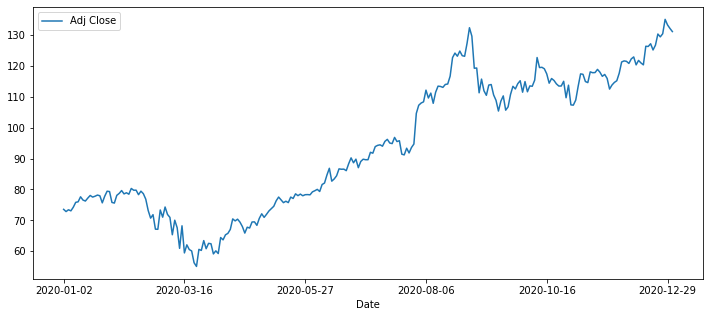

In [ ]:
app.truncate(before='2020-01-01', after='2021-01-01')['Adj Close'].plot(legend=True,figsize=(12,5))

## Volume traded over 1 year

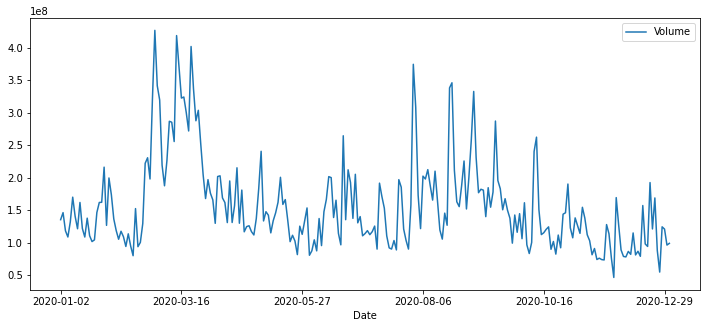

In [ ]:
app.truncate(before='2020-01-01', after='2021-01-01')['Volume'].plot(legend=True,figsize=(12,5))

##Moving Average for Stocks over a 10,20 and 50 day period of time.

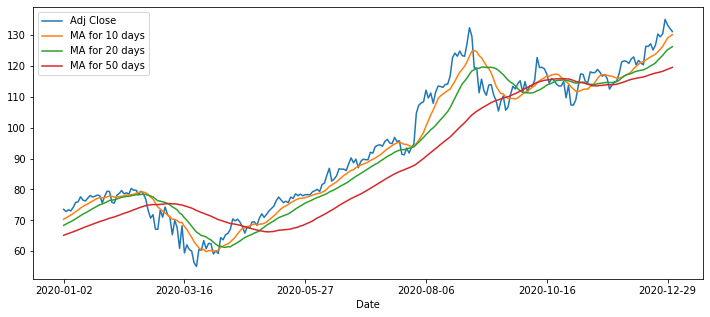

In [ ]:
from pyspark.sql.window import Window
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    app[column_name] = app['Adj Close'].rolling(window=ma,center=False).mean()

app.tail()  
app.truncate(before='2020-01-01', after='2021-01-01')[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False,figsize=(12,5))

##Daily Return Average of the stock

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-11-21  150.160004  150.369995  147.720001  148.009995  148.009995   
2022-11-22  148.130005  150.419998  146.929993  150.179993  150.179993   
2022-11-23  149.449997  151.830002  149.339996  151.070007  151.070007   
2022-11-25  148.309998  148.880005  147.119995  148.110001  148.110001   
2022-11-28  145.139999  146.639999  143.380005  144.220001  144.220001   

              Volume  MA for 10 days  MA for 20 days  MA for 50 days  \
Date                                                                   
2022-11-21  58724100      146.806996      146.676449      146.589732   
2022-11-22  51804100      147.874995      146.581063      146.521627   
2022-11-23  58301400      149.494997      146.679430      146.441972   
2022-11-25  35195900      149.618997      146.856921      146.361819   
2022-11-28  69246000      149.070998      146.293

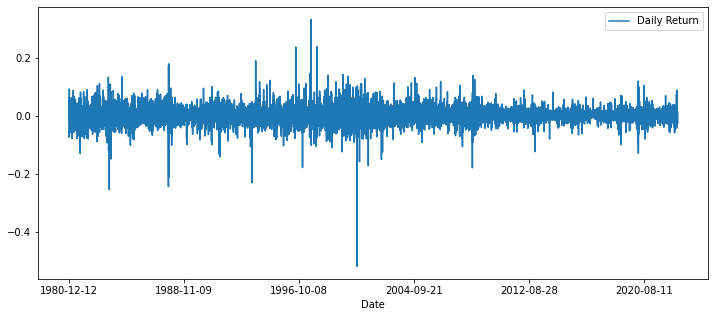

In [ ]:
app['Daily Return'] = (app['Adj Close'] -app['Adj Close'].shift(1)) / (app['Adj Close'].shift(1) )
#microsoft['Daily Return'] = (microsoft['Adj Close'] -microsoft['Adj Close'].shift(1)) / (microsoft['Adj Close'].shift(1) )
print(app.tail())
app['Daily Return'].plot(legend=True,figsize=(12,5))

##Distribution Plot to check return

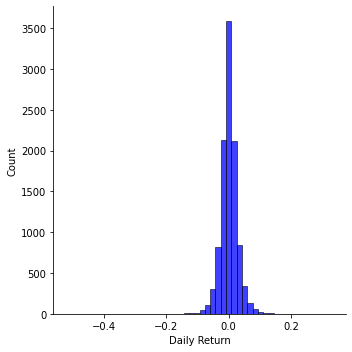

In [ ]:
import seaborn as sns
sns.displot(app['Daily Return'].dropna(),bins=50,color='blue')

## Correlation between daily returns fo Tech Stocks


In [ ]:
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!pip install --upgrade pandas-datareader
start = datetime(2017, 1, 1)
symbols_list = ['apple', 'amazon', 'google', 'intel', 'microsoft','nvdia']
symbols_list = ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'INTC', 'NVDA']
#array to store prices
symbols=[]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for ticker in symbols_list:     
    r = web.DataReader(ticker, 'yahoo', start)   
    # add a symbol column   
    r['Symbol'] = ticker    
    symbols.append(r)
# concatenate into df
df = pd.concat(symbols)
#print(df.tail(10))
df = df.reset_index()
df = df[['Date', 'Close', 'Symbol']]
df.head()
df_pivot=df.pivot('Date','Symbol','Close').reset_index()
df_pivot.head()

Symbol,Date,AAPL,AMZN,GOOGL,INTC,MSFT,NVDA
0,2017-01-03,29.037500,37.683498,40.400501,36.599998,62.580002,25.502501
1,2017-01-04,29.004999,37.859001,40.388500,36.410000,62.299999,26.097500
2,2017-01-05,29.152500,39.022499,40.651001,36.349998,62.299999,25.434999
3,2017-01-06,29.477501,39.799500,41.260502,36.480000,62.840000,25.775000
4,2017-01-09,29.747499,39.846001,41.359001,36.610001,62.639999,26.820000


In [ ]:
corr_df = df_pivot.corr(method='pearson')
# reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
# del corr_df.index.name
corr_df.head(10)

Symbol,AAPL,AMZN,GOOGL,INTC,MSFT,NVDA
Symbol,,,,,,
AAPL,1.000000,0.855540,0.947578,0.085874,0.974497,0.934306
AMZN,0.855540,1.000000,0.846537,0.459645,0.903749,0.826398
GOOGL,0.947578,0.846537,1.000000,0.185250,0.965835,0.965851
INTC,0.085874,0.459645,0.185250,1.000000,0.229573,0.131616
MSFT,0.974497,0.903749,0.965835,0.229573,1.000000,0.939888
NVDA,0.934306,0.826398,0.965851,0.131616,0.939888,1.000000


## Heat Map for correlation

<Figure size 432x288 with 0 Axes>

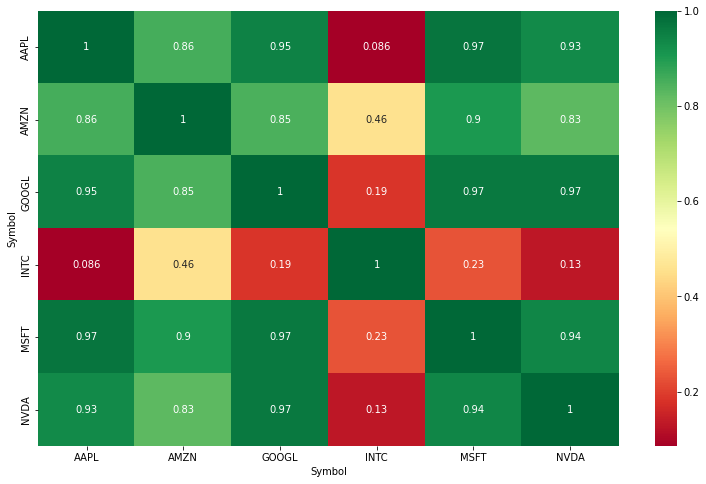

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(13, 8))
sns.heatmap(corr_df, annot=True, cmap="RdYlGn")
plt.figure()

As you can see, except Intel all the others are strongly correlated with each other.

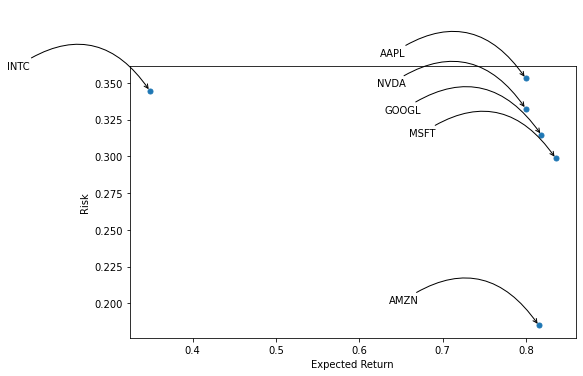

In [ ]:
risk = corr_df.dropna()
plt.figure(figsize=(8,5))

plt.scatter(risk.mean(),risk.std(),s=25)

plt.xlabel('Expected Return')
plt.ylabel('Risk')


#For adding annotatios in the scatterplot
for label,x,y in zip(risk.columns,risk.mean(),risk.std()):
    plt.annotate(
    label,
    xy=(x,y),xytext=(-120,20),
    textcoords = 'offset points', ha = 'right', va = 'bottom',
    arrowprops = dict(arrowstyle='->',connectionstyle = 'arc3,rad=-0.5'))


Intel(INTC) : — High Risk Low Return

Google(GOOG): — High Risk High Return

Microsoft(MSFT): — High Risk High Return

Amazon(AMZN): — Low Risk High Return

Apple(AAPL): — High Risk High Return

NVDIA(NVDA): — Low Risk High Return

##Prediction 


In [ ]:
windowSpec = Window.partitionBy().orderBy("date").rowsBetween(-29, 0)

pdf = _pdf.withColumn('date', F.to_date('date'))
pdf = pdf.withColumn('open', F.avg('open').over(windowSpec))
pdf = pdf.withColumn('high', F.avg('high').over(windowSpec))
pdf = pdf.withColumn('low', F.avg('low').over(windowSpec))
pdf = pdf.withColumn('close', F.avg('close').over(windowSpec))
pdf = pdf.withColumn('Volume', F.avg('Volume').over(windowSpec))

targetWindowSpec = Window.rowsBetween(0, 90)

pdf = pdf.withColumn('Adj Close plus 90 days', F.last('Adj Close').over(targetWindowSpec))
pdf.show()

+----------+-------------------+-------------------+-------------------+-------------------+---------+--------------------+----------------------+
|      date|               open|               high|                low|              close|Adj Close|              Volume|Adj Close plus 90 days|
+----------+-------------------+-------------------+-------------------+-------------------+---------+--------------------+----------------------+
|1980-12-12|           0.128348|           0.128906|           0.128348|           0.128348| 0.099874|          4.690336E8|              0.101611|
|1980-12-15|           0.125279|           0.125558|              0.125|              0.125| 0.094663|          3.224592E8|              0.100742|
|1980-12-16|0.12127966666666667|0.12146566666666668|0.12090766666666668|0.12090766666666668| 0.087715|2.5021546666666666E8|              0.099874|
|1980-12-17|           0.119838|           0.120117|           0.119559|           0.119559| 0.089886|           2.092

In [ ]:
#assembler = VectorAssembler(inputCols=['high', 'low', 'open', 'close', 'volume'], outputCol="features")
assembler = VectorAssembler(inputCols=['high', 'low', 'open', 'close', 'Volume'], outputCol="features")
stages = [assembler]

pipeline = Pipeline(stages=stages)

pipelineModel = pipeline.fit(pdf)

pdf = pipelineModel.transform(pdf)
pdf.show()

+----------+-------------------+-------------------+-------------------+-------------------+---------+--------------------+----------------------+--------------------+
|      date|               open|               high|                low|              close|Adj Close|              Volume|Adj Close plus 90 days|            features|
+----------+-------------------+-------------------+-------------------+-------------------+---------+--------------------+----------------------+--------------------+
|1980-12-12|           0.128348|           0.128906|           0.128348|           0.128348| 0.099874|          4.690336E8|              0.101611|[0.128906,0.12834...|
|1980-12-15|           0.125279|           0.125558|              0.125|              0.125| 0.094663|          3.224592E8|              0.100742|[0.125558,0.125,0...|
|1980-12-16|0.12127966666666667|0.12146566666666668|0.12090766666666668|0.12090766666666668| 0.087715|2.5021546666666666E8|              0.099874|[0.12146566666

In [ ]:
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    pdf = pdf.withColumn(name, F.split('date', '-')[index])

pdf.show(n=10)

+----------+-------------------+-------------------+-------------------+-------------------+---------+--------------------+----------------------+--------------------+----+-----+---+
|      date|               open|               high|                low|              close|Adj Close|              Volume|Adj Close plus 90 days|            features|year|month|day|
+----------+-------------------+-------------------+-------------------+-------------------+---------+--------------------+----------------------+--------------------+----+-----+---+
|1980-12-12|           0.128348|           0.128906|           0.128348|           0.128348| 0.099874|          4.690336E8|              0.101611|[0.128906,0.12834...|1980|   12| 12|
|1980-12-15|           0.125279|           0.125558|              0.125|              0.125| 0.094663|          3.224592E8|              0.100742|[0.125558,0.125,0...|1980|   12| 15|
|1980-12-16|0.12127966666666667|0.12146566666666668|0.12090766666666668|0.12090766666

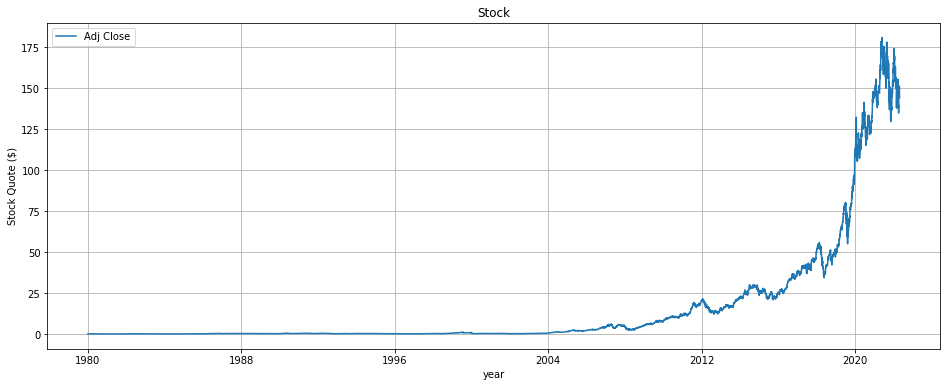

In [ ]:
from matplotlib import pyplot as plt
df_plot = pdf.select('year', 'Adj Close').toPandas()
%matplotlib inline
df_plot.set_index('year', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title('Stock')
plt.ylabel('Stock Quote ($)')
plt.show()

In [ ]:
prediction_df = pdf[pdf.year >= 2017]
testing_df = pdf[pdf.year < 2017]
testing_df = testing_df[pdf.year > 2005]

(trainingData, testData) = testing_df.randomSplit([0.8, 0.2])

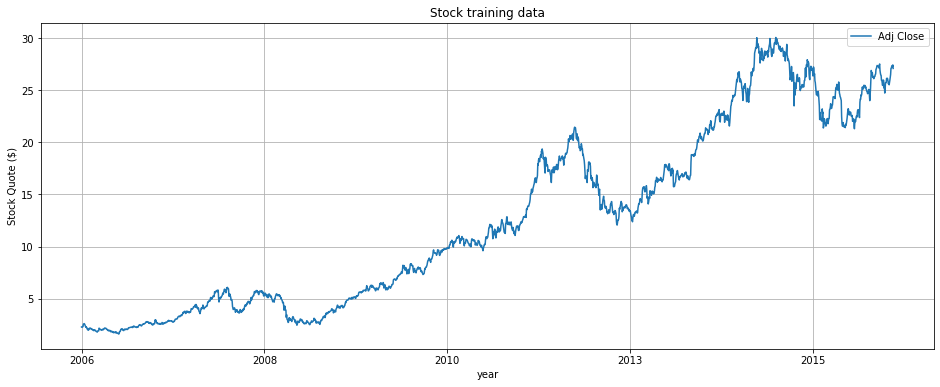

In [ ]:
trainingData_plot = trainingData.select('year', 'Adj Close').toPandas()
trainingData_plot.set_index('year', inplace=True)
trainingData_plot.plot(figsize=(16, 6), grid=True)
plt.title('Stock training data')
plt.ylabel('Stock Quote ($)')
plt.show()

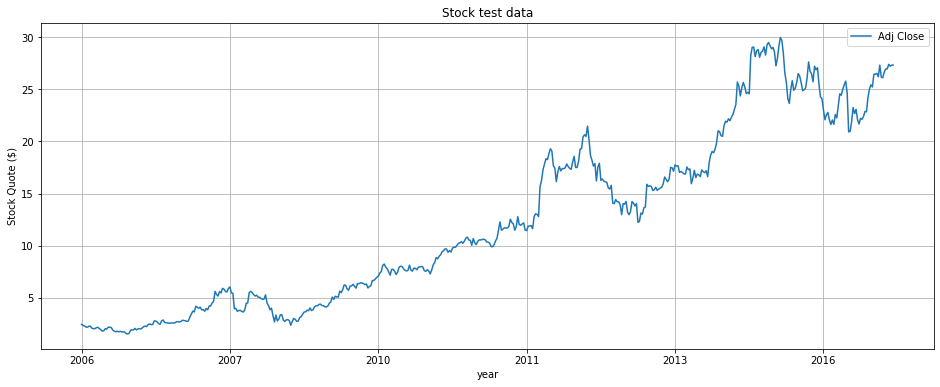

In [ ]:
testData_plot = testData.select('year', 'Adj Close').toPandas()
testData_plot.set_index('year', inplace=True)
testData_plot.plot(figsize=(16, 6), grid=True)
plt.title('Stock test data')
plt.ylabel('Stock Quote ($)')
plt.show()

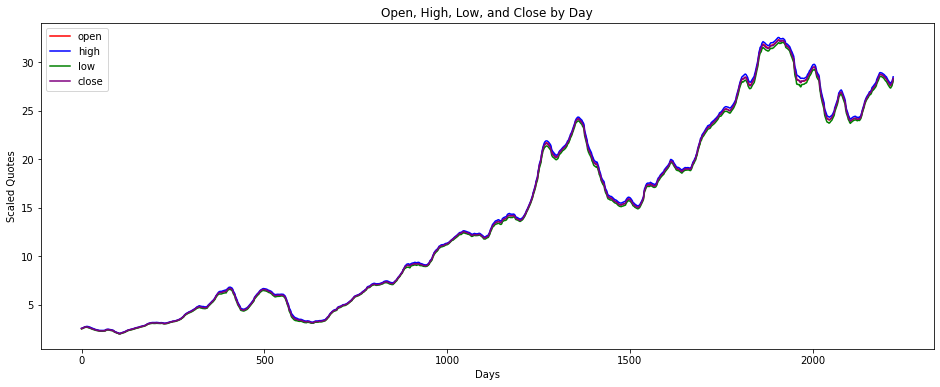

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(trainingData.select('open').toPandas(),color='red', label='open')
plt.plot(trainingData.select('high').toPandas(),color='blue', label='high')
plt.plot(trainingData.select('low').toPandas(),color='green', label='low')
plt.plot(trainingData.select('close').toPandas(),color='purple', label='close')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low, and Close by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

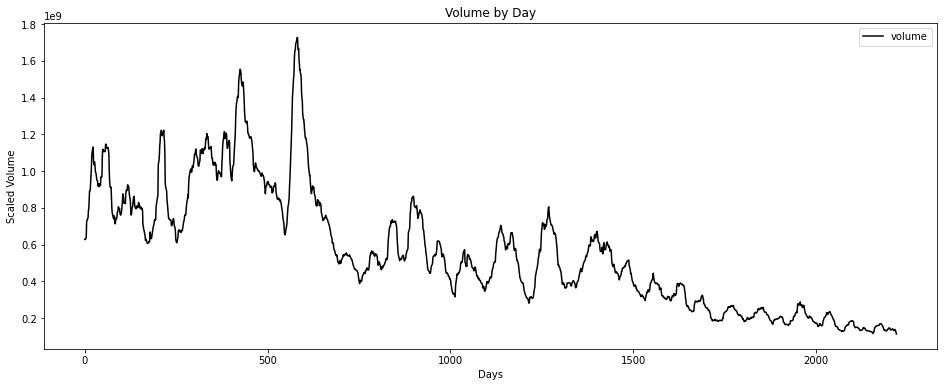

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(trainingData.select('volume').toPandas(),color='black', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

In [345]:
dtr = LinearRegression(labelCol="Adj Close plus 90 days", featuresCol="features")

model = dtr.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(labelCol="Adj Close plus 90 days", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.64068


+----------+------------------+------------------+------------------+------------------+---------+--------------------+----------------------+--------------------+----+-----+---+------------------+
|      date|              open|              high|               low|             close|Adj Close|              Volume|Adj Close plus 90 days|            features|year|month|day|        prediction|
+----------+------------------+------------------+------------------+------------------+---------+--------------------+----------------------+--------------------+----+-----+---+------------------+
|2017-01-03|28.314999866666664|28.557416600000003|28.194083333333328|28.394666733333338|27.174757|             1.136E8|             36.831306|[28.5574166000000...|2017|   01| 03|30.065817090816665|
|2017-01-04|28.366083199999995|28.607166633333343|        28.2448333|28.444333400000005|27.144341|1.1262522666666667E8|             36.736912|[28.6071666333333...|2017|   01| 04|30.094247931199707|
|2017-01-0

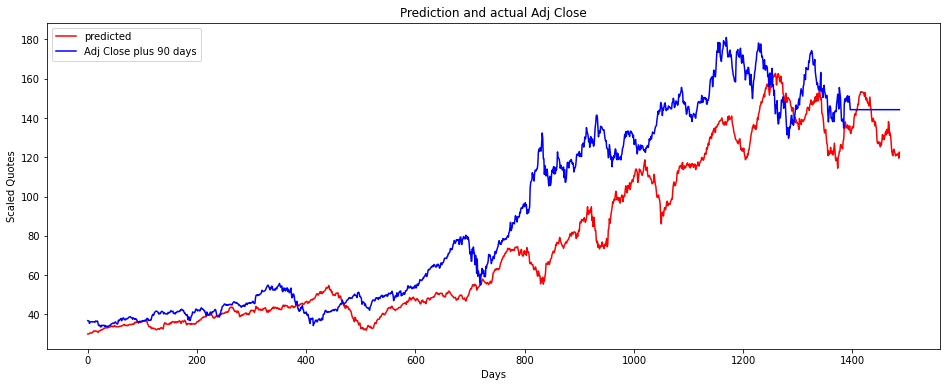

In [ ]:
prediction = model.transform(prediction_df)
prediction.show()
plt.figure(figsize=(16,6))
plt.plot(prediction.select('prediction').toPandas(),color='red', label='predicted')
plt.plot(prediction.select('Adj Close plus 90 days').toPandas(),color='blue', label='Adj Close plus 90 days')
plt.legend(loc = 'upper left')
plt.title('Prediction and actual Adj Close')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()